# Simple Pipeline Example with diabetes dataset and linear regression

...

## Dependencies

We will use **pipesai** with **pandas**, **sklearn** and **numpy** to showcase a simple pipeline architecture.

In [1]:
%matplotlib inline

from dependency_injector import providers
from dependency_injector import containers

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from typing import Tuple, Any

## TODO:
# from pipesai.all import *

import matplotlib.pyplot as plt

import importlib

## Pipeline Layout

### Concepts

A pipeline consists of **Stages** and **Resources**, and their **Links** to one another. A **Link** can either be an **Input** which has a single **Resource** as its *source* and possibly multiple **Stages** as its *targets*, or an **Output** which receives generated data from a *source* **Stage** forwarding it to a single **Resource** *target*.

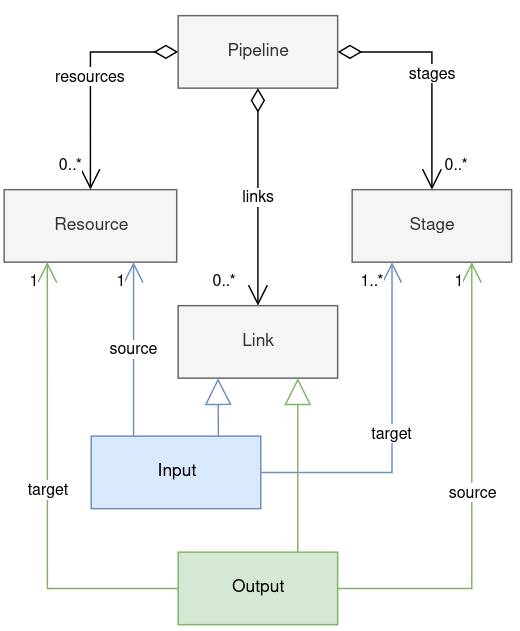

## Case Study

The diabetes dataset from sklearn is a simple example on which we can perform a linear regression learning.

Here we are going to define some stages for our learning pipeline. In this simple example we will stick to the following steps:
- **Load**:
    - Load the data of interest and provide it in a format and structure that we want to work with.
- **Split**:
    - Split the data into train and test data
- **Train**:
    - Train on the training data and build a model
- **Test**
    - Test the trained model on the testdata

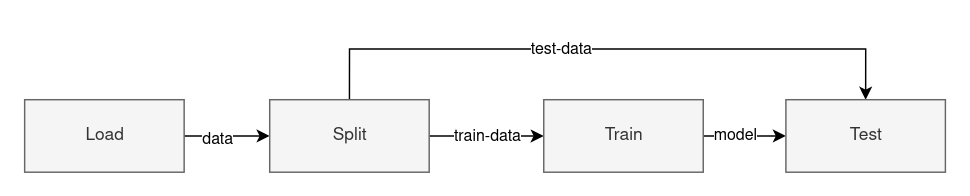

### Stages

A stage is just a processing step that expects specific inputs and generates outputs.

**LoadData** is a stage where we load some data with an arbitrary service connection (here we use an example dataset from sklearn) and convert it to our desired format (DataFrame).

In [2]:
from pipesai.pipeline import Stage

#### Load

In [3]:
class LoadData(Stage):
    
    def run(self) -> Any:
        # Load the diabetes dataset
        diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True, as_frame=True)
        
        diabetes = pd.concat([diabetes_X, pd.DataFrame(diabetes_y)], axis=1)

        # Use only one feature
        diabetes = diabetes[['age', 'target']]
        return self.out(dataset=diabetes)

In [4]:
loaded = LoadData().run()
data = loaded['dataset']
data

,age,target
0,0.038076,151.0
1,-0.001882,75.0
2,0.085299,141.0
3,-0.089063,206.0
4,0.005383,135.0
...,...,...
437,0.041708,178.0
438,-0.005515,104.0
439,0.041708,132.0
440,-0.045472,220.0


#### Split

Our **SplitData** stage resembles a aplitting of some input data into train and test data sets and returns those as named outputs.

In [5]:
class SplitData(Stage):
    
    def run(self, data_in: pd.DataFrame) -> Any:
        
        train, test = train_test_split(data_in, test_size=0.2)
    
        return self.out(train=train, test=test)
        

##### How can you unit test a Stage?

That is very simple, depending on the framework you just create a function àla `test_something_stage` and work with clearly controled inputs and outputs.
In the below test function we assert that the split generated the correctly sized datasets and that for each column none of the train samples are within the test samples and vice versa.

In [6]:
def test_split_stage():
    splitter = SplitData()
    
    data = pd.DataFrame.from_dict({"a": [0,1,2,3,4,5,6,7,8,9], "b": [9,8,7,6,5,4,3,2,1,0]})
    splitted = splitter.run(data)
    assert len(splitted["train"]) == 8
    assert len(splitted["test"]) == 2
    
    assert not any([val in splitted["test"]["a"].to_numpy() for val in splitted["train"]["a"].to_numpy()])
    assert not any([val in splitted["train"]["b"].to_numpy() for val in splitted["test"]["b"].to_numpy()])
    
test_split_stage()

In [7]:
splitted = SplitData().run(data)
splitted

{'train':           age  target
 174  0.016281   151.0
 291  0.074401   248.0
 195  0.027178   122.0
 317  0.019913   190.0
 192  0.056239    91.0
 ..        ...     ...
 93  -0.049105    96.0
 72   0.063504   202.0
 212  0.067136    73.0
 234  0.045341   246.0
 258  0.078034    89.0
 
 [353 rows x 2 columns],
 'test':           age  target
 119  0.016281   200.0
 253  0.081666   150.0
 128 -0.052738   115.0
 409 -0.052738   181.0
 326  0.045341   131.0
 ..        ...     ...
 66  -0.009147   150.0
 292  0.009016    84.0
 316  0.016281   220.0
 257 -0.027310    63.0
 435 -0.012780    64.0
 
 [89 rows x 2 columns]}

#### Train

Let's create the training stage for our model. The inputs are just the training samples and the output is our trained model.

In [8]:
# TODO decorators for convenience
# @Inputs("train_in")
# @Outputs("model", _as=PickleResource)
class Train(Stage):
    
    def __init__(self, model, target_label):
        self._model = model
        self._target_label = target_label
    
    def run(self, train_in: pd.DataFrame):
        self._model.fit(train_in.drop(columns=[self._target_label]), train_in[self._target_label])
        
        return self.out(model=self._model)
        

In [9]:
trained_model = Train(linear_model.LinearRegression(), "target").run(splitted['train'])["model"]
trained_model.coef_

array([259.83885212])

#### Test

Finally, in the test stage we accept the testing data and our trained model to evaluate the performance and eventually create some plot for further visual analysis.

In [10]:
class Test(Stage):
    
    def __init__(self, target_label):
        self._target_label = target_label
        
    def _create_plot(self, x: pd.DataFrame, y: pd.DataFrame, y_pred):
        # Plot outputs
        fig, axs = plt.subplots(nrows=1, sharex=True)
        fig.set_dpi(400)

        axs.scatter(x, y, color="black")
        axs.plot(x, y_pred, color="blue", linewidth=3)

        plt.xticks(())
        plt.yticks(())
        plt.close()
        return fig

    def run(self, model, test_in: pd.DataFrame):
        x = test_in.drop(columns=[self._target_label])
        y = test_in[self._target_label]
        y_pred = model.predict(x)
        
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        metrics = {
            "mse": mse,
            "r2": r2
        }
        
        fig = self._create_plot(x.to_numpy(), y.to_numpy(), y_pred)


        return self.out(metrics=metrics, fig=fig)
        

In [11]:
tested = Test("target").run(trained_model, splitted['test'])
tested['fig'].savefig("test.png")

### Pipeline Setup

In [12]:
from pipesai.pipeline import Pipeline, PipelineLink, PipelineStep
from pipesai.impl.pipeline import ParquetResource, PickleResource, PlotResource, JsonResource

In [13]:
steps = {
    "load": PipelineStep(stage=LoadData(), ins=[], outs=["dataset"]),
    
    "split": PipelineStep(stage=SplitData(), ins=["data_in"], outs=["train", "test"]),
    
    "train": PipelineStep(stage=Train(linear_model.LinearRegression(), "target"), ins=["train_in"], outs=["model"]),
    
    "test": PipelineStep(stage=Test("target"), ins=["model", "test_in"], outs=["metrics", "fig"])
}

In [14]:
resources = [
    ParquetResource(rid="load/dataset"),
    ParquetResource(rid="split/train"),
    ParquetResource(rid="split/test"),
    PickleResource(rid="train/model"),
    PlotResource(rid="test/fig"),
    JsonResource(rid="test/metrics")
]

In [15]:
links = [
    PipelineLink(src="load/dataset", dst="split/data_in"),
    PipelineLink(src="split/train", dst="train/train_in"),
    PipelineLink(src="split/test", dst="test/test_in"),
    PipelineLink(src="train/model", dst="test/model"),
]

In [16]:
pipeline = Pipeline(
    steps=steps,
    resources=resources,
    links=links)

### Running

In [17]:
pipeline.execute("load")
pipeline.execute("split")
pipeline.execute("train")
pipeline.execute("test")


Running stage "load" ...


Running stage "split" ...


Running stage "train" ...


Running stage "test" ...



### Visualization

In [18]:
from pipesai.visualization import DotGraphWriterForNxGraph

from graphviz import Digraph
import io
import graphviz

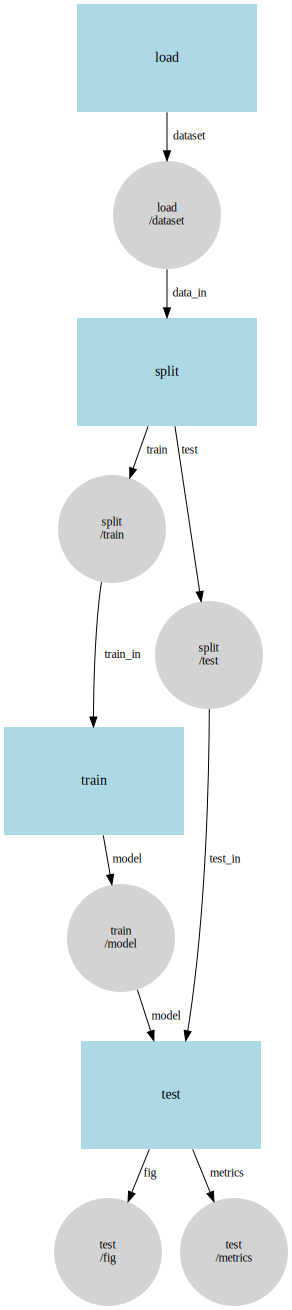

In [19]:
dot = io.StringIO()
writer = DotGraphWriterForNxGraph(dot)
pipeline.accept_graph_visitor(writer)
graphviz.Source(dot.getvalue())